In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import copy
#import sklearn.datasets
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg
import time
from scipy.io import loadmat
import re
import torch as t
import pandas as pd

In [26]:
device=t.device("cuda:0")

In [27]:
class AUC:
    def __init__(self,A,lamb,n=10000,SMALL=True):
        N,d=A.shape
        A0=A[:(n),:(d-1)]
        b=A[:(n),(d-1)]
        Ap=A0[np.where(b==1)[0],]
        An=A0[np.where(b==0)[0],]
        n_p=Ap.shape[0]
        n_n=An.shape[0]
     #   print(0)
        self.Ap=Ap.to(device)
        self.An=An.to(device)
        self.nn=n_n
        self.np=n_p
        self.n=n_n+n_p
        self.dim=d-1
        self.p=n_p/self.n
        self.lamb=lamb
     #   print(1)
        self.H_wu= -2*(1-self.p)*t.sum(self.Ap,0).reshape(self.dim,1)/self.n
        self.H_wv= -2*self.p*t.sum(self.An,0).reshape(self.dim,1)/self.n
        self.H_wy=-2*(1-self.p)*t.sum(self.Ap,0).reshape(self.dim,1)/self.n+2*self.p*t.sum(self.An,0).reshape(self.dim,1)/self.n
        self.H_uu= (self.lamb+2*(1-self.p)*self.np/self.n) * 1
        self.H_vv= (self.lamb+2*self.p*self.nn/self.n) * 1
        self.H_yy= -2*self.p*(1-self.p)
        self.hesdiagx=self.hes_diag_x()      
        if SMALL:
            self.Hessian=self.hes()
            self.Hsquare=self.Hessian@self.Hessian
            eigens = t.linalg.eigh(self.Hessian)[0]
            self.L, mu = eigens[-1], eigens[0]
            self.kappa=self.L/mu
        
    def grad(self,z):
        lamb=self.lamb
        w=z[:self.dim]
        u=z[self.dim]
        v=z[self.dim+1]
        y=z[self.dim+2]
        gw=lamb * w +2*(1-self.p)*(self.Ap.T@((self.Ap@w)-u-(1+y)))/self.n+2*self.p*(self.An.T@((self.An@w)-v+1+y))/self.n
        gu=lamb * u -2*(1-self.p)*(t.sum(self.Ap@w-u))/self.n
        gv=lamb * v -2*self.p*t.sum(self.An@w-v)/self.n
        gy=2*self.p*(1-self.p)*y+2*(1-self.p)*t.sum(self.Ap@w)/self.n-2*self.p*t.sum(self.An@w)/self.n
        gy=-gy
        gz=t.zeros(self.dim+3).double()
        gz[:self.dim]=gw
        gz[self.dim]=gu
        gz[self.dim+1]=gv
        gz[self.dim+2]=gy
        return gz.double().to(device)
    
    def Hxy(self):
        p=self.p
        H_wy=-2*(1-p)*t.sum(self.Ap,0).reshape(self.dim,1)/self.n+2*p*t.sum(self.An,0).reshape(self.dim,1)/self.n
        H_xy=t.zeros([self.dim+2,1]).double().to(device)
        H_xy[:self.dim,0]=H_wy.reshape(-1)  
        return H_xy.double().to(device)

    def Hyy(self):
        p=self.p
        H_yy= t.Tensor([[-2*p*(1-p)]])
        return H_yy.double().to(device)
    
    def hes(self):
        H=t.zeros([self.dim+3,self.dim+3]).double().to(device)
        p=self.p
        H_ww= t.eye(self.dim).double().to(device) * self.lamb +2*(1-p)*t.matmul(self.Ap.T,self.Ap)/self.n + 2*self.p*(t.matmul(self.An.T,self.An))/self.n
        H_uu= (self.lamb+2*(1-self.p)*self.np/self.n) * 1
        H_vv= (self.lamb+2*self.p*self.nn/self.n) * 1
        H_yy= -2*p*(1-p) 
        H_wu= -2*(1-p)*t.sum(self.Ap,0).reshape(self.dim,1)/self.n
        H_wv= -2*p*t.sum(self.An,0).reshape(self.dim,1)/self.n
        H_uw=H_wu.T
        H_vw=H_wv.T       
        H_wy=-2*(1-p)*t.sum(self.Ap,0).reshape(self.dim,1)/self.n+2*p*t.sum(self.An,0).reshape(self.dim,1)/self.n
        H_xx=t.zeros([(self.dim+2),(self.dim+2)]).double().to(device)
        H_xx[:self.dim,:self.dim]=H_ww
        H_xx[self.dim,self.dim]=H_uu
        H_xx[self.dim+1,self.dim+1]=H_vv
        H_xx[:self.dim,self.dim]=H_wu.reshape(-1)
        H_xx[:self.dim,self.dim+1]=H_wv.reshape(-1)
        H_xx[self.dim,:self.dim]=H_uw
        H_xx[self.dim+1,:self.dim]=H_vw
        H_xy=t.zeros([self.dim+2,1]).double().to(device)
        H_xy[:self.dim,0]=H_wy.reshape(-1)      
        H[:self.dim+2,:self.dim+2]=H_xx
        H[self.dim+2,self.dim+2]=H_yy
        H[:self.dim,self.dim+2]=H_wy.reshape(-1)
        H[self.dim+2,:self.dim]=H_wy.reshape(-1)
        return H
    
    def hes_vec(self,g):
        p=self.p
        hes_vect=t.zeros([self.dim+3]).double()
#         H_wu= -2*(1-p)*np.sum(self.Ap,0).reshape(self.dim,1)/self.n
#         H_wv= -2*p*np.sum(self.An,0).reshape(self.dim,1)/self.n
#         H_wy=-2*(1-p)*np.sum(self.Ap,0).reshape(self.dim,1)/self.n+2*p*np.sum(self.An,0).reshape(self.dim,1)/self.n
#         H_uu= (self.lamb+2*(1-self.p)*self.np/self.n) * 1
#         H_vv= (self.lamb+2*self.p*self.nn/self.n) * 1
#         H_yy= np.array([-2*p*(1-p)]) 
        gw=g[:self.dim]
        gu=g[self.dim]
        gv=g[self.dim+1]
        gy=g[self.dim+2]
        Hhw=self.lamb*gw+2*(1-p)/self.n*self.Ap.T@(self.Ap@gw)+2*p/self.n*(self.An.T@(self.An@gw))
        H_wu=self.H_wu.reshape(-1)
        H_wv=self.H_wv.reshape(-1)
        H_wy=self.H_wy.reshape(-1)
        Hhw=Hhw.reshape(-1)
        hes_vect[:self.dim]=Hhw+gu*H_wu+gv*H_wv+gy*H_wy
        hes_vect[self.dim]=H_wu.T@gw+self.H_uu*gu
        hes_vect[self.dim+1]=H_wv.T@gw+self.H_vv*gv
        hes_vect[self.dim+2]=self.H_yy*gy+H_wy.T@gw
        return hes_vect.double().to(device)
    
    def hes_vec_x(self, g):
        p=self.p
        hes_vect=t.zeros([self.dim+2]).double()
#         H_wu= -2*(1-p)*np.sum(self.Ap,0).reshape(self.dim,1)/self.n
#         H_wv= -2*p*np.sum(self.An,0).reshape(self.dim,1)/self.n
#         H_wy=-2*(1-p)*np.sum(self.Ap,0).reshape(self.dim,1)/self.n+2*p*np.sum(self.An,0).reshape(self.dim,1)/self.n
#         H_uu= (self.lamb+2*(1-self.p)*self.np/self.n) * 1
#         H_vv= (self.lamb+2*self.p*self.nn/self.n) * 1
#         H_yy= np.array([-2*p*(1-p)]) 
        gw=g[:self.dim]
        gu=g[self.dim]
        gv=g[self.dim+1]
        # gy=g[self.dim+2]
        Hhw=self.lamb * gw + 2 * (1 - p) / self.n * self.Ap.T @ (self.Ap @ gw) + 2 * p / self.n * (self.An.T @ (self.An @ gw))
        # Hhw=self.lamb * gw
        H_wu=self.H_wu.reshape(-1)
        H_wv=self.H_wv.reshape(-1)
        # H_wy=self.H_wy.reshape(-1)
        Hhw=Hhw.reshape(-1)
        # hes_vect[:self.dim]=Hhw+gu*H_wu+gv*H_wv+gy*H_wy
        hes_vect[:self.dim]=Hhw + gu * H_wu + gv * H_wv
        hes_vect[self.dim]=H_wu.T@gw+self.H_uu*gu
        hes_vect[self.dim+1]=H_wv.T@gw+self.H_vv*gv
        return hes_vect.double().to(device)
    
    def hes_diag_x(self):
        p=self.p
        hes_diag_vec = t.zeros([self.dim + 2]).double()
        hes_diag_w = self.lamb + 2 * p * (self.An ** 2).sum(dim=0) / self.n + 2 * (1 - p) * (self.Ap ** 2).sum(dim=0) / self.n
        hes_diag_u = self.lamb + 2 * (1 - p) * p 
        hes_diag_v = self.lamb + 2 * (1 - p) * p 
        hes_diag_vec[:self.dim] = hes_diag_w
        hes_diag_vec[self.dim] = hes_diag_u
        hes_diag_vec[self.dim + 1] = hes_diag_v
        return hes_diag_vec.to(device)

    # def hes_vec_x(self, g):
    #     H = self.hes()
    #     return H[:self.dim + 2, :self.dim + 2] @ g

    # def hes_vec(self, g):
    #     H = self.hes()
    #     return H @ g

In [28]:
def randomSR1_sol(w,L,epochs,corr=False):
    G=L*t.eye(oracle.dim+3).double().to(device)
    invG = 1/L * t.eye(oracle.dim+3).double().to(device)
    gw = oracle.grad(w)
    d = oracle.dim+3
    res = [t.linalg.norm(gw)]
  # check_vu=[]
  #  check_hvu=[]
  #  check_dw=[]
    ts = time.time()
    times = [0]
    M = 2
    for i in range(epochs):
        dw = - invG @ oracle.hes_vec(gw)
        if corr:
            r = t.linalg.norm(dw)
            invG = invG / (1 + M * r) # proposed by authors
        w = w + dw
  #     check_dw.append(t.linalg.norm(dw))
        u = t.randn(d,1).double().to(device)
        u=u/t.linalg.norm(u)
        #Gu = G @ u
        Au = oracle.hes_vec(u)
        Hu = oracle.hes_vec(Au).reshape(oracle.dim+3,1)
        
        #G = G - Gu @ Gu.T / (u.T @ Gu) + Hu @ Hu.T / (Au.T @ Au)
        

        v = invG @ Hu
   #     check_vu.append(t.linalg.norm(v-u))
        temp=oracle.hes_vec(oracle.hes_vec(u-v))
    #    check_hvu.append(t.linalg.norm(temp))
        invG = invG + (u - v) @ ((u - v).T / (u.T@temp+1e-20) )
        gw = oracle.grad(w)
        # if(t.linalg.norm(gw)>res[-1]):
        #   return check_v,res,times
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if i%50 ==0:
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

In [29]:
def inverse(invGxx, Hxy, Hyy):
    C2 = Hyy - Hxy.T @ invGxx @ Hxy
    temp = invGxx @ Hxy
    invC1 = invGxx + temp @ ((1/C2) @ temp.T)
    invGxy = -invC1 @ (Hxy @ (1/Hyy))

    invG = t.zeros(oracle.dim + 3, oracle.dim + 3).double().to(device)
    invG[:oracle.dim + 2, :oracle.dim + 2] = invC1
    invG[:oracle.dim + 2, oracle.dim+2: oracle.dim+3] = invGxy
    invG[oracle.dim+2:oracle.dim+3, :oracle.dim + 2] = invGxy.T
    invG[oracle.dim + 2, oracle.dim + 2] = (1/C2)

    return invG

In [30]:
def fast_randomSR1_sol(w, L, epochs, corr=False):
 #   Gxx=L*t.eye(oracle.dim+2).double().to(device)
    invGxx = 1 / L * t.eye(oracle.dim + 2).double().to(device)
    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy()
    invG = inverse(invGxx, Hxy, Hyy)
    gw = oracle.grad(w)
    d = oracle.dim + 3
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times = [0]
    M = 2

    for i in range(epochs):
        # dw = - invG @ oracle.hes_vec(gw)
        dw = - invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            #invGxx = invG[: d - 1, : d - 1] / (1 + M * r)
            # invG[: d - 1, : d - 1] = invG[: d - 1, : d - 1] / (1 + M * r)
            # invG = invG / (1 + M * r) # proposed by authors
        w = w + dw
      # check_dw.append(t.linalg.norm(dw))
        u = t.randn(d - 1, 1).double().to(device)
       #u = u / t.linalg.norm(u)
        Au = oracle.hes_vec_x(u).reshape(d-1,1)
       # Hu = oracle.hes_vec_x(Au).reshape(oracle.dim + 2, 1)

        v = invGxx @ Au
        temp = oracle.hes_vec_x(u - v)
        invGxx = invGxx + (u - v) @ ((u - v).T / (u.T @ temp + 1e-20) )
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ ((1/C2) @ temp.T)
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.dim + 2, :oracle.dim + 2] = invC1
        invG[:oracle.dim + 2, oracle.dim+2: oracle.dim+3] = invGxy
        invG[oracle.dim+2:oracle.dim+3, :oracle.dim + 2] = invGxy.T
        invG[oracle.dim + 2, oracle.dim + 2] = (1/C2)
        gw = oracle.grad(w)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if i%50 ==0:
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

In [31]:
def fast_greedySR1_sol(w, L, epochs, corr=False):
    Gxx = L * t.eye(oracle.dim + 2).double().to(device)
    invGxx = 1 / L * t.eye(oracle.dim + 2).double().to(device)
    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy()
    invG = inverse(invGxx, Hxy, Hyy)
    gw = oracle.grad(w)
    d = oracle.dim + 3
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times = [0]
    M = 2

    for i in range(epochs):
        # dw = - invG @ oracle.hes_vec(gw)
        dw = - invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invG[: d - 1, : d - 1] / (1 + M * r)
            Gxx = Gxx * (1 + M * r)
            # invG[: d - 1, : d - 1] = invG[: d - 1, : d - 1] / (1 + M * r)
            # invG = invG / (1 + M * r) # proposed by authors
        w = w + dw
      # check_dw.append(t.linalg.norm(dw))
        ind = t.argmax(Gxx.diag() - oracle.hesdiagx)
        u = t.zeros([d - 1, 1]).double().to(device)
        u[ind] = 1

        Gxxu = Gxx @ u
        Au = oracle.hes_vec_x(u).reshape(d-1,1)
       # Hu = oracle.hes_vec_x(Au).reshape(oracle.dim + 2, 1)
        Gxx = Gxx - (Gxxu - Au) @ ((Gxxu - Au).T / (u.T @ (Gxxu - Au) + 1e-20))

        v = invGxx @ Au
        temp = oracle.hes_vec_x(u - v)
        invGxx = invGxx + (u - v) @ ((u - v).T / (u.T @ temp + 1e-20) )
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ ((1/C2) @ temp.T)
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.dim + 2, :oracle.dim + 2] = invC1
        invG[:oracle.dim + 2, oracle.dim+2: oracle.dim+3] = invGxy
        invG[oracle.dim+2:oracle.dim+3, :oracle.dim + 2] = invGxy.T
        invG[oracle.dim + 2, oracle.dim + 2] = (1/C2)
        gw = oracle.grad(w)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if i%50 ==0:
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

In [32]:
def randomBroyden_sol(w,L,epochs,corr=False):
    G=L*t.eye(oracle.dim+3).double().to(device)
    invG = 1/L * t.eye(oracle.dim+3).double().to(device)
    gw = oracle.grad(w)
    d=oracle.dim+3
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times= [0]
 #   print(res[-1])
    for i in range(epochs):
        dw = - invG @ oracle.hes_vec(gw)
        if corr:
            r = np.sqrt(dw.T @ oracle.hes_vec(dw))
            invG = invG / (1 + oracle.M * r) # proposed by authors
        w = w + dw
        u = t.randn(d, 1).double().to(device)
        #Gu = G @ u
        Au = oracle.hes_vec(u)
        Hu = oracle.hes_vec(Au).reshape(oracle.dim+3,1)
        
        #G = G - Gu @ (Gu.T / (u.T @ Gu)) + Hu @ (Hu.T / (Au.T @ Au)
        
        v = u.T @ Hu
        tmp = (invG @ Hu) @ (u.T / v)
        invG = invG - tmp.T - tmp + u @ ((Hu.T @ tmp) / v) + u @ (u.T / v)
        gw = oracle.grad(w)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if(i%50==0):
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

In [33]:
def fast_randomBroyd_sol(w, L, epochs, corr=False):
 #   Gxx=L*t.eye(oracle.dim+2).double().to(device)
    invGxx = 1 / L * t.eye(oracle.dim + 2).double().to(device)
    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy()
    invG = inverse(invGxx, Hxy, Hyy)
    gw = oracle.grad(w)
    d = oracle.dim + 3
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times = [0]
    M = 2

    for i in range(epochs):
        # dw = - invG @ oracle.hes_vec(gw)
        dw = - invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
            # invG[: d - 1, : d - 1] = invG[: d - 1, : d - 1] / (1 + M * r)
            # invG = invG / (1 + M * r) # proposed by authors
        w = w + dw
      # check_dw.append(t.linalg.norm(dw))
        u = t.randn(d - 1, 1).double().to(device)
        u = u / t.linalg.norm(u)
        Au = oracle.hes_vec_x(u).reshape(d-1,1)
       # Hu = oracle.hes_vec_x(Au).reshape(oracle.dim + 2, 1)
        v = u.T @ Au
        tmp = (invGxx @ Au) @ (u.T / v)
        invGxx = invGxx - tmp.T - tmp + u @ ((Au.T @ tmp) / v) + u @ (u.T / v)
        gw = oracle.grad(w) 
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ ((1/C2) @ temp.T)
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.dim + 2, :oracle.dim + 2] = invC1
        invG[:oracle.dim + 2, oracle.dim+2: oracle.dim+3] = invGxy
        invG[oracle.dim+2:oracle.dim+3, :oracle.dim + 2] = invGxy.T
        invG[oracle.dim + 2, oracle.dim + 2] = (1/C2)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if i%50 ==0:
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

In [34]:
def fast_greedyBroyd_sol(w, L, epochs, corr=False):
 #   Gxx=L*t.eye(oracle.dim+2).double().to(device)
    Gxx = L * t.eye(oracle.dim + 2).double().to(device)
    invGxx = 1 / L * t.eye(oracle.dim + 2).double().to(device)
    Hxy = oracle.Hxy()
    Hyy = oracle.Hyy()
    invG = inverse(invGxx, Hxy, Hyy)
    gw = oracle.grad(w)
    d = oracle.dim + 3
    res = [t.linalg.norm(gw)]
    ts = time.time()
    times = [0]
    M = 2

    for i in range(epochs):
        # dw = - invG @ oracle.hes_vec(gw)
        dw = - invG @ gw
        if corr:
            r = t.linalg.norm(dw)
            invGxx = invGxx / (1 + M * r)
            # invG[: d - 1, : d - 1] = invG[: d - 1, : d - 1] / (1 + M * r)
            # invG = invG / (1 + M * r) # proposed by authors
        w = w + dw
      # check_dw.append(t.linalg.norm(dw))
        ind = t.argmax(Gxx.diag() / oracle.hesdiagx)
        u = t.zeros([d-1, 1]).double().to(device)
        u[ind] = 1
        Gxxu = Gxx @ u
        Au = oracle.hes_vec_x(u).reshape(d-1,1)
        Gxx = Gxx - Gxxu @ (Gxxu.T / (u.T @ Gxxu)) + Au @ (Au.T / (u.T @ Au))
        v = u.T @ Au
        tmp = (invGxx @ Au) @ (u.T / v)
        invGxx = invGxx - tmp.T - tmp + u @ ((Au.T @ tmp) / v) + u @ (u.T / v)
        gw = oracle.grad(w)        
        C2 = Hyy - Hxy.T @ invGxx @ Hxy
        temp = invGxx @ Hxy
        invC1 = invGxx + temp @ ((1/C2) @ temp.T)
        invGxy = -invC1 @ (Hxy @ (1/Hyy))
        invG[:oracle.dim + 2, :oracle.dim + 2] = invC1
        invG[:oracle.dim + 2, oracle.dim+2: oracle.dim+3] = invGxy
        invG[oracle.dim+2:oracle.dim+3, :oracle.dim + 2] = invGxy.T
        invG[oracle.dim + 2, oracle.dim + 2] = (1/C2)
        res.append(t.linalg.norm(gw))
        times.append(time.time()-ts)
        if i%50 ==0:
            print("epoches:",i,", gradient norm:", res[-1].item())
    print(res[-1])
    return w,res,times

## w8a

In [35]:
m = loadmat('w8a.mat')
A0=np.array(m['A']).astype("float")
b1=np.array(m['b']).astype("float")
b1[np.where(b1==-1)[0]]=0
A1=np.hstack((A0,b1))
A2=t.from_numpy(A1).double()

### $\lambda = 0.1/m $

In [12]:
oracle=AUC(A2, 0.1/A2.shape[0],A2.shape[0],True)

In [13]:
oracle.p

0.028981688842049796

In [14]:
w0=t.zeros(oracle.dim+3).double().to(device)
w2,sr1,tsr1=randomSR1_sol(w0,10,400,False)

epoches: 0 , gradient norm: 0.05302216510354475
epoches: 50 , gradient norm: 0.009516878228859188
epoches: 100 , gradient norm: 0.005057394341455111
epoches: 150 , gradient norm: 0.003404435047224057
epoches: 200 , gradient norm: 0.0014009424734856054
epoches: 250 , gradient norm: 0.00031078672203588027
epoches: 300 , gradient norm: 3.330650269496801e-06
epoches: 350 , gradient norm: 0.00016956043098324532
tensor(3.9146e-18, device='cuda:0', dtype=torch.float64)


In [15]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3, sr_fast, tsr_fast = fast_randomSR1_sol(w0, 1, 400, False)

epoches: 0 , gradient norm: 0.04629036167369405
epoches: 50 , gradient norm: 0.005941678120162296
epoches: 100 , gradient norm: 0.0029546591211207234
epoches: 150 , gradient norm: 0.002041876611407516
epoches: 200 , gradient norm: 0.0014203708745007333
epoches: 250 , gradient norm: 0.0003991807685759944
epoches: 300 , gradient norm: 4.373659920060831e-06
epoches: 350 , gradient norm: 4.639492939317262e-18
tensor(3.6497e-18, device='cuda:0', dtype=torch.float64)


In [16]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, sr_fast_gr, tsr_fast_gr = fast_greedySR1_sol(w0, 1, 400, False)

epoches: 0 , gradient norm: 0.04629036167369405
epoches: 50 , gradient norm: 0.007191376101012915
epoches: 100 , gradient norm: 0.0037379718869066146
epoches: 150 , gradient norm: 0.0025101855481573093
epoches: 200 , gradient norm: 0.0016792082749358228
epoches: 250 , gradient norm: 0.001160183260311057
epoches: 300 , gradient norm: 0.0004937952349770936
epoches: 350 , gradient norm: 8.098000538350139e-18
tensor(3.4795e-18, device='cuda:0', dtype=torch.float64)


In [17]:
rsr1=np.array([x.item() for x in sr1])
rsr_fast = np.array([x.item() for x in sr_fast])
grsr1=np.array([x.item() for x in sr_fast_gr])

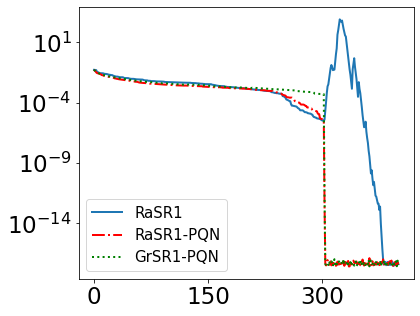

In [18]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1, '-', label='RaSR1',  linewidth=2)
plt.plot(rsr_fast, '-.', label='RaSR1-PQN', color='red' ,linewidth=2)
plt.plot(grsr1[:2000], ':', label='GrSR1-PQN', color = 'green' ,linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.xticks([0,150,300])
plt.savefig("aucw8ares01.pdf",bbox_inches="tight",dpi=600,format="pdf")

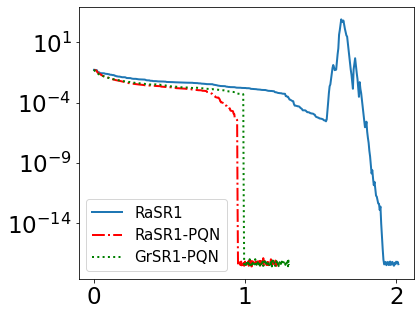

In [19]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1,rsr1, '-', label='RaSR1', linewidth=2)
plt.plot(tsr_fast,rsr_fast, '-.', label='RaSR1-PQN', color='red', linewidth=2)
plt.plot(tsr_fast_gr,grsr1, ':', label='GrSR1-PQN', color = 'green',linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.savefig("aucw8atime01.pdf",bbox_inches="tight",dpi=600,format="pdf")

### $\lambda = 0.01/m$ 

In [20]:
oracle=AUC(A2, 0.01/A2.shape[0],A2.shape[0],True)

In [21]:
w0=t.zeros(oracle.dim+3).double().to(device)
w2,sr1,tsr1=randomSR1_sol(w0,10,400,False)

epoches: 0 , gradient norm: 0.053022166984010896
epoches: 50 , gradient norm: 0.011492797019543885
epoches: 100 , gradient norm: 0.005746493089071699
epoches: 150 , gradient norm: 0.002967155185237
epoches: 200 , gradient norm: 0.0013964731256740418
epoches: 250 , gradient norm: 0.00016770141642556712
epoches: 300 , gradient norm: 4657625973022.889
epoches: 350 , gradient norm: 2.7705132403018894e+100
tensor(inf, device='cuda:0', dtype=torch.float64)


In [22]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3, sr_fast, tsr_fast = fast_randomSR1_sol(w0, 1, 400, False)

epoches: 0 , gradient norm: 0.046290461113297675
epoches: 50 , gradient norm: 0.005444938384382663
epoches: 100 , gradient norm: 0.003121490825658334
epoches: 150 , gradient norm: 0.001976479274656879
epoches: 200 , gradient norm: 0.0013570515621390577
epoches: 250 , gradient norm: 0.00046274180739492345
epoches: 300 , gradient norm: 3.107280904365223e-07
epoches: 350 , gradient norm: 4.557356450372878e-18
tensor(3.3080e-18, device='cuda:0', dtype=torch.float64)


In [23]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, sr_fast_gr, tsr_fast_gr = fast_greedySR1_sol(w0, 1, 400, False)

epoches: 0 , gradient norm: 0.046290461113297675
epoches: 50 , gradient norm: 0.00719134716470687
epoches: 100 , gradient norm: 0.003738867441548445
epoches: 150 , gradient norm: 0.002511821286657465
epoches: 200 , gradient norm: 0.0016807890185930386
epoches: 250 , gradient norm: 0.001162456093490619
epoches: 300 , gradient norm: 0.0004952222111606761
epoches: 350 , gradient norm: 5.848559330601181e-18
tensor(5.7396e-18, device='cuda:0', dtype=torch.float64)


In [24]:
rsr1=np.array([x.item() for x in sr1])
rsr_fast = np.array([x.item() for x in sr_fast])
grsr1=np.array([x.item() for x in sr_fast_gr])

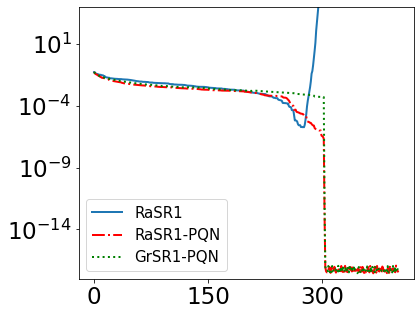

In [25]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1, '-', label='RaSR1',  linewidth=2)
plt.plot(rsr_fast, '-.', label='RaSR1-PQN', color='red' ,linewidth=2)
plt.plot(grsr1, ':', label='GrSR1-PQN', color = 'green' ,linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.ylim([1e-18,1e4])
plt.yticks([1e-14,1e-9,1e-4,1e1])
plt.xticks([0,150,300])
plt.savefig("aucw8ares001.pdf",bbox_inches="tight",dpi=600,format="pdf")

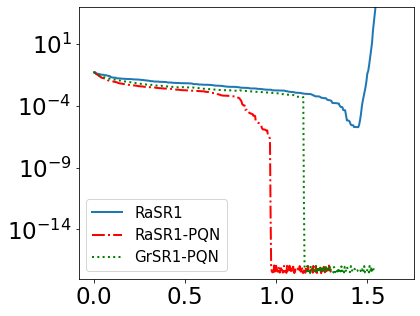

In [26]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1[:320],rsr1[:320], '-', label='RaSR1', linewidth=2)
plt.plot(tsr_fast,rsr_fast, '-.', label='RaSR1-PQN', color='red', linewidth=2)
plt.plot(tsr_fast_gr,grsr1, ':', label='GrSR1-PQN', color = 'green',linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.ylim([1e-18,1e4])
plt.yticks([1e-14,1e-9,1e-4,1e1])
plt.savefig("aucw8atime001.pdf",bbox_inches="tight",dpi=600,format="pdf")

### $\lambda = 1/m$

In [27]:
oracle=AUC(A2, 1/A2.shape[0],A2.shape[0],True)

In [28]:
w0=t.zeros(oracle.dim+3).double().to(device)
w2,sr1,tsr1=randomSR1_sol(w0,10,400,False)

epoches: 0 , gradient norm: 0.053022146296605836
epoches: 50 , gradient norm: 0.009553561144735117
epoches: 100 , gradient norm: 0.005015817921652199
epoches: 150 , gradient norm: 0.003436275612322513
epoches: 200 , gradient norm: 0.0017479279712613765
epoches: 250 , gradient norm: 0.000420484003455523
epoches: 300 , gradient norm: 2.5914894879865335e-05
epoches: 350 , gradient norm: 1.0952089693076865e-17
tensor(3.3275e-18, device='cuda:0', dtype=torch.float64)


In [29]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3, sr_fast, tsr_fast = fast_randomSR1_sol(w0, 1, 400, False)

epoches: 0 , gradient norm: 0.04628936727778252
epoches: 50 , gradient norm: 0.005626613970571179
epoches: 100 , gradient norm: 0.0033815064343994164
epoches: 150 , gradient norm: 0.00224755854903193
epoches: 200 , gradient norm: 0.001153998521794595
epoches: 250 , gradient norm: 0.0005019512408931194
epoches: 300 , gradient norm: 1.0787319670161287e-05
epoches: 350 , gradient norm: 7.499373206569361e-18
tensor(7.3733e-18, device='cuda:0', dtype=torch.float64)


In [30]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, sr_fast_gr, tsr_fast_gr = fast_greedySR1_sol(w0, 1, 400, False)

epoches: 0 , gradient norm: 0.04628936727778252
epoches: 50 , gradient norm: 0.007187970959333017
epoches: 100 , gradient norm: 0.003725872450274601
epoches: 150 , gradient norm: 0.0024916182739303963
epoches: 200 , gradient norm: 0.0016639688419376791
epoches: 250 , gradient norm: 0.0011390948381506754
epoches: 300 , gradient norm: 0.00048025777042040124
epoches: 350 , gradient norm: 3.872248138543158e-18
tensor(7.3157e-18, device='cuda:0', dtype=torch.float64)


In [31]:
rsr1=np.array([x.item() for x in sr1])
rsr_fast = np.array([x.item() for x in sr_fast])
grsr1=np.array([x.item() for x in sr_fast_gr])

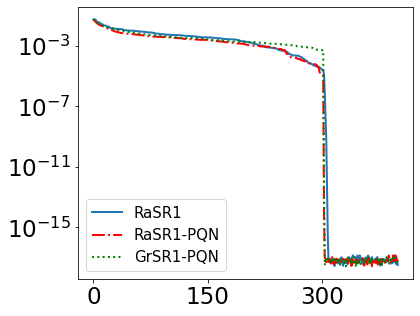

In [32]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1, '-', label='RaSR1',  linewidth=2)
plt.plot(rsr_fast, '-.', label='RaSR1-PQN', color='red' ,linewidth=2)
plt.plot(grsr1[:2000], ':', label='GrSR1-PQN', color = 'green' ,linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.xticks([0,150,300])
plt.savefig("aucw8ares1x.pdf",bbox_inches="tight",dpi=600,format="pdf")

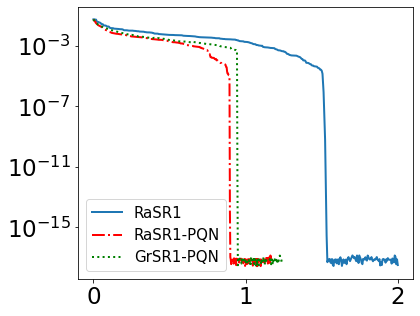

In [33]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1,rsr1, '-', label='RaSR1', linewidth=2)
plt.plot(tsr_fast,rsr_fast, '-.', label='RaSR1-PQN', color='red', linewidth=2)
plt.plot(tsr_fast_gr,grsr1, ':', label='GrSR1-PQN', color = 'green',linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.savefig("aucw8atime1x.pdf",bbox_inches="tight",dpi=600,format="pdf")

In [34]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3,broyd,tbroyd=randomBroyden_sol(w0,1,3000)

epoches: 0 , gradient norm: 0.05209859451824766
epoches: 50 , gradient norm: 0.014894846742381665
epoches: 100 , gradient norm: 0.0077723793506517145
epoches: 150 , gradient norm: 0.005047871793680242
epoches: 200 , gradient norm: 0.0037347954702766206
epoches: 250 , gradient norm: 0.0029985831081681736
epoches: 300 , gradient norm: 0.002471423757875064
epoches: 350 , gradient norm: 0.0020326348717167307
epoches: 400 , gradient norm: 0.001666943494627663
epoches: 450 , gradient norm: 0.0013655050842651156
epoches: 500 , gradient norm: 0.0011272088581645602
epoches: 550 , gradient norm: 0.0009425588613604343
epoches: 600 , gradient norm: 0.0007967941655926756
epoches: 650 , gradient norm: 0.0006872525117734898
epoches: 700 , gradient norm: 0.0005960763947976778
epoches: 750 , gradient norm: 0.0005154359922742022
epoches: 800 , gradient norm: 0.000449071498839162
epoches: 850 , gradient norm: 0.00039696803296910047
epoches: 900 , gradient norm: 0.00035691882583497686
epoches: 950 , gradi

In [35]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, broyd_fast_gr, tbroydr = fast_greedyBroyd_sol(w0, 1, 2000, False)

epoches: 0 , gradient norm: 0.04628936727778252
epoches: 50 , gradient norm: 0.007202705793891197
epoches: 100 , gradient norm: 0.0037321007406716715
epoches: 150 , gradient norm: 0.0026565281708478246
epoches: 200 , gradient norm: 0.0017649518187196542
epoches: 250 , gradient norm: 0.001243834129581393
epoches: 300 , gradient norm: 0.0005212971774470913
epoches: 350 , gradient norm: 1.3604696708413938e-05
epoches: 400 , gradient norm: 7.280053167297614e-07
epoches: 450 , gradient norm: 7.35242087076711e-08
epoches: 500 , gradient norm: 1.4368160336934552e-09
epoches: 550 , gradient norm: 5.274273104861987e-11
epoches: 600 , gradient norm: 1.6318713412914952e-12
epoches: 650 , gradient norm: 2.1588589314214833e-14
epoches: 700 , gradient norm: 2.628797560518859e-16
epoches: 750 , gradient norm: 1.176157448245238e-17
epoches: 800 , gradient norm: 5.394918451109859e-18
epoches: 850 , gradient norm: 9.783204807266144e-18
epoches: 900 , gradient norm: 7.589424953403098e-18
epoches: 950 , g

In [36]:
t.cuda.empty_cache()

In [37]:
w0=t.zeros(oracle.dim+3).double().to(device)
wbroydf,broydf,tbroydf=fast_randomBroyd_sol(w0,1,2000)

epoches: 0 , gradient norm: 0.04628936727778252
epoches: 50 , gradient norm: 0.005626939722534311
epoches: 100 , gradient norm: 0.003136335495326857
epoches: 150 , gradient norm: 0.0020774628315888663
epoches: 200 , gradient norm: 0.0014812153645869742
epoches: 250 , gradient norm: 0.0008280386109224817
epoches: 300 , gradient norm: 0.00037050507071467064
epoches: 350 , gradient norm: 0.00020100635586495422
epoches: 400 , gradient norm: 0.0001080074995934108
epoches: 450 , gradient norm: 6.172145578106897e-05
epoches: 500 , gradient norm: 4.170858666280524e-05
epoches: 550 , gradient norm: 3.4164262419680726e-05
epoches: 600 , gradient norm: 2.182104460745776e-05
epoches: 650 , gradient norm: 1.4314155117648995e-05
epoches: 700 , gradient norm: 9.421544506698597e-06
epoches: 750 , gradient norm: 6.128374915100799e-06
epoches: 800 , gradient norm: 4.080203070608557e-06
epoches: 850 , gradient norm: 2.4249627803072927e-06
epoches: 900 , gradient norm: 1.514560912676813e-06
epoches: 950 ,

In [38]:
rsr1=np.array([x.item() for x in sr1])
rsr_fast = np.array([x.item() for x in sr_fast])
grsr1=np.array([x.item() for x in sr_fast_gr])
rbfgs=np.array([x.item() for x in broyd])
rbfgs_fast=np.array([x.item() for x in broydf])
grbfgs=np.array([x.item() for x in broyd_fast_gr])

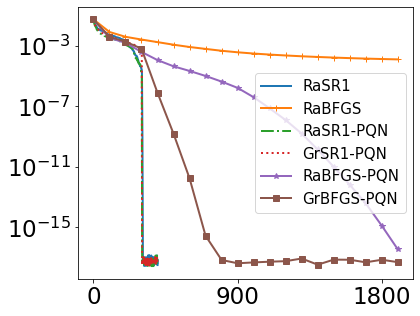

In [39]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1, '-', label='RaSR1',  linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:2000]), 100), rbfgs[:2000:100],'-+', label='RaBFGS', linewidth=2)
plt.plot(rsr_fast, '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(grsr1[:2000], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:2000]), 100), rbfgs_fast[:2000:100], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:2000]), 100),grbfgs[:2000:100], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.xticks([0,900,1800])
plt.savefig("aucw8ares1.pdf",bbox_inches="tight",dpi=600,format="pdf")

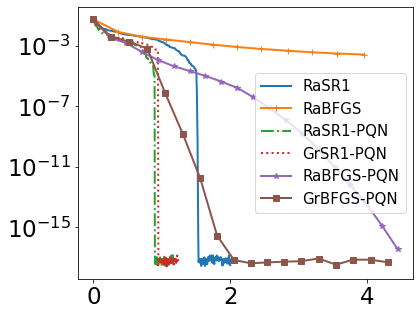

In [40]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1,rsr1, '-', label='RaSR1', linewidth=2)
plt.plot(tbroyd[:1200:100],rbfgs[:1200:100], '-+', label='RaBFGS', linewidth=2)
plt.plot(tsr_fast,rsr_fast, '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(tsr_fast_gr[:1800],grsr1[:1800], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(tbroydf[:2000:100], rbfgs_fast[:2000:100], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(tbroydr[:1800:100], grbfgs[:1800:100], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.yscale('log')
plt.savefig("aucw8atime1.pdf",bbox_inches="tight",dpi=600,format="pdf")

## A9a

In [41]:
m = loadmat('a9a.mat')
A0=np.array(m['A']).astype("float")
b1=np.array(m['b']).astype("float")
b1[np.where(b1==-1)[0]]=0
A1=np.hstack((A0,b1))
A2=t.from_numpy(A1).double()

In [42]:
oracle=AUC(A2,1/A2.shape[0],A2.shape[0],True)

In [43]:
oracle.p

0.2408095574460244

In [44]:
w0=t.zeros(oracle.dim+3).double().to(device)
w2,sr1,tsr1=randomSR1_sol(w0,1000,2000,False)

epoches: 0 , gradient norm: 0.42788661437265446
epoches: 50 , gradient norm: 0.01706127822346978
epoches: 100 , gradient norm: 0.0002801744367442214
epoches: 150 , gradient norm: 6410238.154617614
epoches: 200 , gradient norm: 1.0191042309304176e+74
epoches: 250 , gradient norm: 1.7468018463025335e+98
epoches: 300 , gradient norm: 1.2783003568879391e+153
epoches: 350 , gradient norm: inf
epoches: 400 , gradient norm: inf
epoches: 450 , gradient norm: inf
epoches: 500 , gradient norm: nan
epoches: 550 , gradient norm: nan
epoches: 600 , gradient norm: nan
epoches: 650 , gradient norm: nan
epoches: 700 , gradient norm: nan
epoches: 750 , gradient norm: nan
epoches: 800 , gradient norm: nan
epoches: 850 , gradient norm: nan
epoches: 900 , gradient norm: nan
epoches: 950 , gradient norm: nan
epoches: 1000 , gradient norm: nan
epoches: 1050 , gradient norm: nan
epoches: 1100 , gradient norm: nan
epoches: 1150 , gradient norm: nan
epoches: 1200 , gradient norm: nan
epoches: 1250 , gradient n

In [45]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3, sr_fast, tsr_fast = fast_randomSR1_sol(w0, 1, 400, False)

epoches: 0 , gradient norm: 0.24066463167413538
epoches: 50 , gradient norm: 0.0034413993278696207
epoches: 100 , gradient norm: 0.0006150160503120133
epoches: 150 , gradient norm: 8.53967834560677e-17
epoches: 200 , gradient norm: 7.062734785060409e-17
epoches: 250 , gradient norm: 1.124918859714198e-16
epoches: 300 , gradient norm: 6.316146927141864e-17
epoches: 350 , gradient norm: 6.557509885912888e-17
tensor(9.7042e-17, device='cuda:0', dtype=torch.float64)


In [46]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, sr_fast_gr, tsr_fast_gr = fast_greedySR1_sol(w0, 10, 400, False)

epoches: 0 , gradient norm: 0.3796838645390204
epoches: 50 , gradient norm: 0.04848738639398846
epoches: 100 , gradient norm: 0.017057310131986483
epoches: 150 , gradient norm: 9.391672616759181e-17
epoches: 200 , gradient norm: 8.531430636432305e-17
epoches: 250 , gradient norm: 1.0018056422566273e-16
epoches: 300 , gradient norm: 8.939212562116635e-17
epoches: 350 , gradient norm: 7.894355038536217e-17
tensor(6.2845e-17, device='cuda:0', dtype=torch.float64)


In [47]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3,broyd,tbroyd=randomBroyden_sol(w0,10,3000)

epoches: 0 , gradient norm: 0.41125220317401173
epoches: 50 , gradient norm: 0.05267489887825503
epoches: 100 , gradient norm: 0.0260413156189652
epoches: 150 , gradient norm: 0.015310524289012938
epoches: 200 , gradient norm: 0.009636422208181679
epoches: 250 , gradient norm: 0.0059885603629725075
epoches: 300 , gradient norm: 0.00400195940261028
epoches: 350 , gradient norm: 0.0030885034786164523
epoches: 400 , gradient norm: 0.002613726857571734
epoches: 450 , gradient norm: 0.0023156971149470933
epoches: 500 , gradient norm: 0.0020813124673263812
epoches: 550 , gradient norm: 0.0018874924831192498
epoches: 600 , gradient norm: 0.0017299205776257762
epoches: 650 , gradient norm: 0.0016021422377648234
epoches: 700 , gradient norm: 0.0014949791271280063
epoches: 750 , gradient norm: 0.001401744775472698
epoches: 800 , gradient norm: 0.0013180314065316802
epoches: 850 , gradient norm: 0.0012437612056079546
epoches: 900 , gradient norm: 0.0011771113756384192
epoches: 950 , gradient norm

In [48]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, broyd_fast_gr, tbroydr = fast_greedyBroyd_sol(w0, 10, 2000, False)

epoches: 0 , gradient norm: 0.3796838645390204
epoches: 50 , gradient norm: 0.0484933778003256
epoches: 100 , gradient norm: 0.017247142620313582
epoches: 150 , gradient norm: 0.00016735490724096674
epoches: 200 , gradient norm: 1.8086075832413397e-05
epoches: 250 , gradient norm: 2.181366109917467e-05
epoches: 300 , gradient norm: 1.1051619635113754e-05
epoches: 350 , gradient norm: 8.05579266371825e-06
epoches: 400 , gradient norm: 6.223366507403941e-06
epoches: 450 , gradient norm: 5.814671139410388e-06
epoches: 500 , gradient norm: 4.520247231884732e-06
epoches: 550 , gradient norm: 3.30130211529903e-06
epoches: 600 , gradient norm: 2.333827233756535e-06
epoches: 650 , gradient norm: 1.965902244675207e-06
epoches: 700 , gradient norm: 1.4338625724484825e-06
epoches: 750 , gradient norm: 1.1006417822492795e-06
epoches: 800 , gradient norm: 8.025583384826408e-07
epoches: 850 , gradient norm: 6.120733217737523e-07
epoches: 900 , gradient norm: 4.17561455322284e-07
epoches: 950 , gradi

In [49]:
w0=t.zeros(oracle.dim+3).double().to(device)
wbroydf,broydf,tbroydf=fast_randomBroyd_sol(w0,1,2000)

epoches: 0 , gradient norm: 0.24066463167413538
epoches: 50 , gradient norm: 0.0020858338050611953
epoches: 100 , gradient norm: 0.0008041554389426656
epoches: 150 , gradient norm: 0.0004569221015360896
epoches: 200 , gradient norm: 0.0002509325533388645
epoches: 250 , gradient norm: 0.000152492491805192
epoches: 300 , gradient norm: 6.459799937694298e-05
epoches: 350 , gradient norm: 4.1811745043038396e-05
epoches: 400 , gradient norm: 2.556060503639348e-05
epoches: 450 , gradient norm: 1.4660071648832673e-05
epoches: 500 , gradient norm: 1.0383289234628503e-05
epoches: 550 , gradient norm: 8.53165241970608e-06
epoches: 600 , gradient norm: 5.151067214558609e-06
epoches: 650 , gradient norm: 4.795253303897429e-06
epoches: 700 , gradient norm: 3.254259343471392e-06
epoches: 750 , gradient norm: 2.484381478159711e-06
epoches: 800 , gradient norm: 1.942659570003172e-06
epoches: 850 , gradient norm: 1.5171951945285068e-06
epoches: 900 , gradient norm: 1.260025851532375e-06
epoches: 950 , 

In [50]:
rsr1=np.array([x.item() for x in sr1])
#rsr1[np.where(rsr1>1)[0][0]:]=1
rsr_fast = np.array([x.item() for x in sr_fast])
grsr1=np.array([x.item() for x in sr_fast_gr])
rbfgs=np.array([x.item() for x in broyd])
rbfgs_fast=np.array([x.item() for x in broydf])
grbfgs=np.array([x.item() for x in broyd_fast_gr])

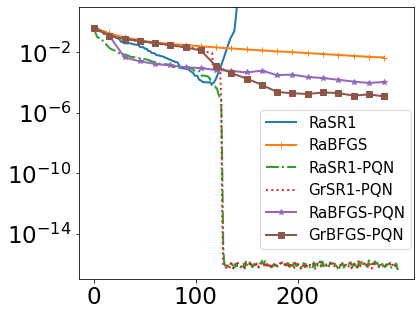

In [51]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1[:300], '-', label='RaSR1',  linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:300]), 15), rbfgs[:300:15],'-+', label='RaBFGS', linewidth=2)
plt.plot(rsr_fast[:300], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(grsr1[:300], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:300]), 15), rbfgs_fast[:300:15], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:300]), 15),grbfgs[:300:15], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
plt.legend()
plt.legend(bbox_to_anchor=(0.52, 0.65))
#plt.grid()
plt.yscale('log')
plt.ylim((1e-17,10))
plt.yticks([1e-14,1e-10,1e-6,1e-2])
plt.xticks([0,100,200])
plt.savefig("auca9ares1.pdf",bbox_inches="tight",dpi=600,format="pdf")

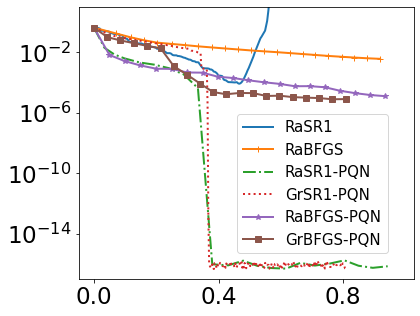

In [56]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1[:250],rsr1[:250], '-', label='RaSR1', linewidth=2)
plt.plot(tbroyd[:330:15],rbfgs[:330:15], '-+', label='RaBFGS', linewidth=2)
plt.plot(tsr_fast[:330:15],rsr_fast[:330:15], '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(tsr_fast_gr[:300],grsr1[:300], ':', label='GrSR1-PQN', linewidth=2)
plt.plot(tbroydf[:500:25], rbfgs_fast[:500:25], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(tbroydr[:400:20], grbfgs[:400:20], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.legend(bbox_to_anchor=(0.45, 0.35))
plt.yscale('log')
plt.ylim((1e-17,10))
plt.yticks([1e-14,1e-10,1e-6,1e-2])
plt.xticks([0,0.4,0.8])
plt.savefig("auca9atime1.pdf",bbox_inches="tight",dpi=600,format="pdf")

## sido0

In [21]:
m = loadmat('sido0.mat')
As=m['A'].toarray().astype("float")
bs=np.array(m['b']).astype("float")
bs[np.where(bs==-1)[0]]=0
Ass=np.hstack((As,bs))
Ass=t.from_numpy(Ass).double()

In [22]:
oracle=AUC(Ass,1/Ass.shape[0],Ass.shape[0],True)

In [23]:
t.cuda.empty_cache()

In [24]:
oracle.p

0.0356523110900773

In [25]:
w0=t.zeros(oracle.dim+3).double().to(device)
w2,sr1,tsr1=randomSR1_sol(w0,3000,5000,False)

epoches: 0 , gradient norm: 0.6692578325423353
epoches: 50 , gradient norm: 0.10222708326746824
epoches: 100 , gradient norm: 0.07634732815911109
epoches: 150 , gradient norm: 0.06135932177507536
epoches: 200 , gradient norm: 0.049281553575074466
epoches: 250 , gradient norm: 0.041820632086420284
epoches: 300 , gradient norm: 0.03691949345774966
epoches: 350 , gradient norm: 0.0334123772275613
epoches: 400 , gradient norm: 0.028830257536317818
epoches: 450 , gradient norm: 0.02603118801456352
epoches: 500 , gradient norm: 0.023066880237839746
epoches: 550 , gradient norm: 0.02136657449894788
epoches: 600 , gradient norm: 0.019370218790839777
epoches: 650 , gradient norm: 0.017854368630574973
epoches: 700 , gradient norm: 0.01644533417747478
epoches: 750 , gradient norm: 0.014783137792444207
epoches: 800 , gradient norm: 0.013720558413937305
epoches: 850 , gradient norm: 0.012758947344761143
epoches: 900 , gradient norm: 0.011661537610930686
epoches: 950 , gradient norm: 0.0104552014850

In [36]:
np.save("sidosr1basis",rsr1)
np.save("sidosr1basis_t",tsr1)

In [39]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3, sr_fast, tsr_fast = fast_randomSR1_sol(w0, 100, 5000, False)

epoches: 0 , gradient norm: 0.5995368651486331
epoches: 50 , gradient norm: 0.03318132686888448
epoches: 100 , gradient norm: 0.029580862020121137
epoches: 150 , gradient norm: 0.027278078668394233
epoches: 200 , gradient norm: 0.025240595510640923
epoches: 250 , gradient norm: 0.02383395590828001
epoches: 300 , gradient norm: 0.021609192138107594
epoches: 350 , gradient norm: 0.019827861380491515
epoches: 400 , gradient norm: 0.018074060393782475
epoches: 450 , gradient norm: 0.016930356062634034
epoches: 500 , gradient norm: 0.0158713717995166
epoches: 550 , gradient norm: 0.014867043055820584
epoches: 600 , gradient norm: 0.013384568008341244
epoches: 650 , gradient norm: 0.01248630214591446
epoches: 700 , gradient norm: 0.011484828057490636
epoches: 750 , gradient norm: 0.010898717466816421
epoches: 800 , gradient norm: 0.010332483143359893
epoches: 850 , gradient norm: 0.009691413933786018
epoches: 900 , gradient norm: 0.009013903189212202
epoches: 950 , gradient norm: 0.008550529

In [41]:
np.save("sidorasr1",np.array([x.item() for x in sr_fast]))
np.save("sidotrasr1",tsr_fast)

In [44]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, sr_fast_gr, tsr_fast_gr = fast_greedySR1_sol(w0, 1000, 5000, False)

epoches: 0 , gradient norm: 0.7147866244534528
epoches: 50 , gradient norm: 0.31957298149836694
epoches: 100 , gradient norm: 0.17455608830391284
epoches: 150 , gradient norm: 0.10322373332201157
epoches: 200 , gradient norm: 0.0681723361612649
epoches: 250 , gradient norm: 0.04763381722126152
epoches: 300 , gradient norm: 0.03999646753190538
epoches: 350 , gradient norm: 0.035708270233929876
epoches: 400 , gradient norm: 0.03359261906304333
epoches: 450 , gradient norm: 0.03280301439871211
epoches: 500 , gradient norm: 0.03201267862576745
epoches: 550 , gradient norm: 0.03133625922823646
epoches: 600 , gradient norm: 0.031115676625814232
epoches: 650 , gradient norm: 0.03127441064311618
epoches: 700 , gradient norm: 0.030478087862026083
epoches: 750 , gradient norm: 0.030176299922015207
epoches: 800 , gradient norm: 0.03004912193141068
epoches: 850 , gradient norm: 0.029995557804213174
epoches: 900 , gradient norm: 0.029996646395500804
epoches: 950 , gradient norm: 0.03016311712277903

In [45]:
np.save("sidogrsr1",grsr1)
np.save("sidotgrsr1",tsr_fast_gr)

In [46]:
w0=t.zeros(oracle.dim+3).double().to(device)
w3,broyd,tbroyd=randomBroyden_sol(w0,1000,15000)

epoches: 0 , gradient norm: 0.5919806676944182
epoches: 50 , gradient norm: 0.11675464013615523
epoches: 100 , gradient norm: 0.09901762418390651
epoches: 150 , gradient norm: 0.08350561109340984
epoches: 200 , gradient norm: 0.07394549174089685
epoches: 250 , gradient norm: 0.06563959988481656
epoches: 300 , gradient norm: 0.05808899653531113
epoches: 350 , gradient norm: 0.05179106364170263
epoches: 400 , gradient norm: 0.04661586159917246
epoches: 450 , gradient norm: 0.042479263693154024
epoches: 500 , gradient norm: 0.03944188803531391
epoches: 550 , gradient norm: 0.03703165160144474
epoches: 600 , gradient norm: 0.03474660429556194
epoches: 650 , gradient norm: 0.032754889590424156
epoches: 700 , gradient norm: 0.030791959286537506
epoches: 750 , gradient norm: 0.02890707936520274
epoches: 800 , gradient norm: 0.027397589757777594
epoches: 850 , gradient norm: 0.02600881326768071
epoches: 900 , gradient norm: 0.024583083076076113
epoches: 950 , gradient norm: 0.02342628192606651

In [50]:
np.save("sidobfgsbasis",  np.array([x.item() for x in broyd]))
np.save("sidotbfgsbasis",tbroyd)

In [51]:
w0=t.zeros(oracle.dim+3).double().to(device)
w4, broyd_fast_gr, tbroydr = fast_greedyBroyd_sol(w0, 1000, 15000, False)

epoches: 0 , gradient norm: 0.7147866244534528
epoches: 50 , gradient norm: 0.3212390230011568
epoches: 100 , gradient norm: 0.17438533208800008
epoches: 150 , gradient norm: 0.10312416991989876
epoches: 200 , gradient norm: 0.06801960002132126
epoches: 250 , gradient norm: 0.04751194701070022
epoches: 300 , gradient norm: 0.04006313354101503
epoches: 350 , gradient norm: 0.035640112367419347
epoches: 400 , gradient norm: 0.03356358694697768
epoches: 450 , gradient norm: 0.03282049815236423
epoches: 500 , gradient norm: 0.03193596157665783
epoches: 550 , gradient norm: 0.03155083003377393
epoches: 600 , gradient norm: 0.031143558413294935
epoches: 650 , gradient norm: 0.03169288396539696
epoches: 700 , gradient norm: 0.03055329817833023
epoches: 750 , gradient norm: 0.030135647427922376
epoches: 800 , gradient norm: 0.030082026718918922
epoches: 850 , gradient norm: 0.030230805060378958
epoches: 900 , gradient norm: 0.030211679362610818
epoches: 950 , gradient norm: 0.03068429603863874

In [52]:
np.save("sidobfgs_gr",np.array([x.item() for x in broyd_fast_gr]))
np.save("sidotbfgsgr",tbroydr)

In [53]:
w0=t.zeros(oracle.dim+3).double().to(device)
wbroydf,broydf,tbroydf=fast_randomBroyd_sol(w0,1000,15000)

epoches: 0 , gradient norm: 0.7147866244534528
epoches: 50 , gradient norm: 0.056564064468372734
epoches: 100 , gradient norm: 0.038795278687714915
epoches: 150 , gradient norm: 0.031093984603601642
epoches: 200 , gradient norm: 0.028740088625915632
epoches: 250 , gradient norm: 0.028081619778673125
epoches: 300 , gradient norm: 0.028395297993822326
epoches: 350 , gradient norm: 0.02572392253259695
epoches: 400 , gradient norm: 0.022680890537185795
epoches: 450 , gradient norm: 0.022547342875644773
epoches: 500 , gradient norm: 0.02156819140796367
epoches: 550 , gradient norm: 0.01955693268443228
epoches: 600 , gradient norm: 0.018061729767910848
epoches: 650 , gradient norm: 0.016701512433283668
epoches: 700 , gradient norm: 0.015976161974679173
epoches: 750 , gradient norm: 0.015382868007231609
epoches: 800 , gradient norm: 0.015468816093567737
epoches: 850 , gradient norm: 0.016065527707053006
epoches: 900 , gradient norm: 0.014365711935518674
epoches: 950 , gradient norm: 0.0127733

In [57]:
np.save("sidorabfgs",np.array([x.item() for x in broydf]))
np.save("sidotrabfgs",tbroydf)

In [58]:
rsr1=np.array([x.item() for x in sr1])
rsr_fast = np.array([x.item() for x in sr_fast])
grsr1=np.array([x.item() for x in sr_fast_gr])
rbfgs=np.array([x.item() for x in broyd])
rbfgs_fast=np.array([x.item() for x in broydf])
grbfgs=np.array([x.item() for x in broyd_fast_gr])

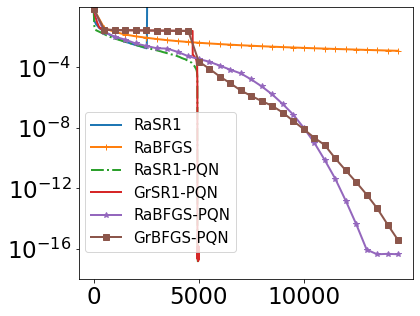

In [60]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(rsr1, '-', label='RaSR1',  linewidth=2)
plt.plot(np.arange(0, len(rbfgs[:15000]), 500), rbfgs[:15000:500],'-+', label='RaBFGS', linewidth=2)
plt.plot(rsr_fast, '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(grsr1, label='GrSR1-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:15000]), 500), rbfgs_fast[:15000:500], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(np.arange(0, len(rbfgs_fast[:15000]), 500),grbfgs[:15000:500], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.legend(loc=(0.02, 0.10))
plt.yscale('log')
plt.ylim((1e-18,1))
plt.yticks([1e-16,1e-12,1e-8,1e-4])
plt.xticks([0,5000,10000])
plt.savefig("aucsido0res1.pdf",bbox_inches="tight",dpi=600,format="pdf")

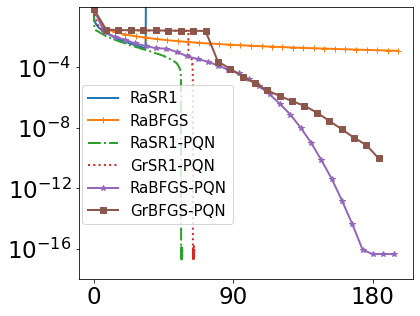

In [63]:
plt.rcParams['figure.figsize'] = (6, 5)
params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.plot(tsr1,rsr1, '-', label='RaSR1', linewidth=2)
plt.plot(tbroyd[:15000:500],rbfgs[:15000:500], '-+', label='RaBFGS', linewidth=2)
plt.plot(tsr_fast,rsr_fast, '-.', label='RaSR1-PQN', linewidth=2)
plt.plot(tsr_fast_gr,grsr1, ':', label='GrSR1-PQN', linewidth=2)
plt.plot(tbroydf[:15000:500], rbfgs_fast[:15000:500], '-*', label='RaBFGS-PQN', linewidth=2)
plt.plot(tbroydr[:12000:500], grbfgs[:12000:500], '-s',label='GrBFGS-PQN', linewidth=2)
plt.tick_params(labelsize=23)
#plt.grid()
plt.legend()
plt.legend(loc=(0.01, 0.20))
plt.yscale('log')
plt.ylim((1e-18,1))
plt.yticks([1e-16,1e-12,1e-8,1e-4])
plt.xticks([0,90,180])
plt.savefig("aucsido0time1.pdf",bbox_inches="tight",dpi=600,format="pdf")

In [11]:
rsr1=np.load("sidosr1basis.npy")
rsr_fast=np.load("sidorasr1.npy")
grsr1=np.load("sidogrsr1.npy")
rbfgs=np.load("sidobfgsbasis.npy")
rbfgs_fast=np.load("sidobfgs.npy")
grbfgs=np.load("sidobfgs_gr.npy")
tsr1=np.load("sidosr1basis_t.npy")
tsr_fast=np.load("sidotrasr1.npy")
tsr_fast_gr=np.load("sidotgrsr1.npy")
tbroyd=np.load("sidotbfgsbasis.npy")
tbroydf=np.load("sidotbfgs.npy")
tbroydr=np.load("sidotbfgsgr.npy")

NameError: name 'rsr1' is not defined

array([0.        , 0.00229049, 0.00576282, 0.00795054, 0.01011992,
       0.0122745 , 0.01441693, 0.01655006, 0.01869202, 0.0208416 ,
       0.02299809, 0.0251348 , 0.02727628, 0.02940488, 0.03154492,
       0.03367805, 0.03581548, 0.0379622 , 0.04011536, 0.04226422,
       0.04439807, 0.04654384, 0.04867029, 0.05079317, 0.0529263 ,
       0.05507684, 0.05721498, 0.05935383, 0.06149721, 0.06363273,
       0.06576395, 0.0678916 , 0.07002735, 0.07216024, 0.07428122,
       0.07641196, 0.07855558, 0.08070254, 0.08283401, 0.08497238,
       0.08719969, 0.08935595, 0.09149885, 0.0936389 , 0.09577727,
       0.09790969, 0.10087013, 0.10419917, 0.10736132, 0.11047959,
       0.1134665 , 0.11653996, 0.12095594, 0.12414718, 0.12725568,
       0.13054633, 0.13379002, 0.13700271, 0.14031792, 0.1435411 ,
       0.14672661, 0.14996004, 0.15317273, 0.1562922 , 0.15959096,
       0.16277266, 0.16593623, 0.16910028, 0.17230749, 0.17544866,
       0.17863679, 0.18169332, 0.18471456, 0.18772221, 0.19075

array([0.        , 0.00434041, 0.00997734, 0.0144043 , 0.01874495,
       0.0236702 , 0.02799463, 0.03231001, 0.03659654, 0.04082274,
       0.04460931, 0.04841018, 0.05223322, 0.05601573, 0.05982184,
       0.06347203, 0.06704783, 0.07070279, 0.07437873, 0.07797384,
       0.08156347, 0.08494711, 0.08835578, 0.09176064, 0.09517384,
       0.09866858, 0.10198188, 0.10508299, 0.108145  , 0.1112287 ,
       0.11429429, 0.1173563 , 0.12044573, 0.12335968, 0.12627077,
       0.12918329, 0.132092  , 0.13499975, 0.13790822, 0.14089155,
       0.14371562, 0.14651394, 0.14924932, 0.15196466, 0.15469503,
       0.15744233, 0.16019845, 0.16268849, 0.16519403, 0.16775227,
       0.17028475, 0.17284298, 0.17626286, 0.1787858 , 0.18131328,
       0.18384624, 0.18637252, 0.1888926 , 0.1914289 , 0.19395256,
       0.19646788, 0.1989882 , 0.20153475, 0.20407224, 0.20721364,
       0.20975876, 0.21229196, 0.21483064, 0.21736574, 0.21990728,
       0.22245574, 0.22498131, 0.22751069, 0.23004103, 0.23261